In [1]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import numpy as np
import jax.numpy as jnp
from jax import random
from jax import vmap
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',family ='Arial',size=10)
import pandas as pd
from jax.scipy.stats import norm 

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GOH
Gasser et al 2006(https://doi.org/10.1098/rsif.2005.0073)


Incompressible material assumption
$$\Psi_1(J) = p(1-J)$$
$$\Psi_2(\mathbf{C}) = \frac{\mu}{2}(I_1 -3) +\frac{k_1}{2k_2}[e^{(k_2[\kappa I_1 + (1-3\kappa)I_4-1]^2)}-1]$$
Here $I_4 = \mathbf{C}:\mathbf{M} =\mathbf{C}:  \mathbf{a}_0\otimes \mathbf{a}_0$

Let $\mathbf{H} =\kappa \mathbf{I} + (1-3\kappa)\mathbf{M}$ 

and $H = \mathbf{H}:\mathbf{C}  =\kappa I_1 + (1-3\kappa)I_4$ and $E = [{H}-1]$

$$\mathbf{S}_1  = 2\frac{\partial \Psi_{1}}{\partial \mathbf{C}} = -pC^{-1} $$
$$\mathbf{S}_2  =  2\frac{\partial \Psi_{2}}{\partial \mathbf{C}} = \mu \mathbf{I} + 2k_1 e^{k_2{E}^2}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK2 stress

$$\mathbf{S} = -p\mathbf{C}^{-1} +  \mu\mathbf{I} + 2k_1 e^{k_2{E}^2}{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK1 stress

$$\mathbf{P} = \mathbf{F}\mathbf{S}$$

In [2]:
def GOH(par, lmx, lmy, lmz):
    mu, k1, k2, kappa, alpha, k1_2, k2_2, kappa2, alpha2 = par
    mu = 0.05*(jnp.tanh(mu)+1)/2
    k1 = 100*(jnp.tanh(k1)+1)/2
    k2 = 1000*(jnp.tanh(k2)+1)/2
    kappa = 0.33*(jnp.tanh(kappa)+1)/2
    k1_2 = 100*(jnp.tanh(k1_2)+1)/2
    k2_2 = 1000*(jnp.tanh(k2_2)+1)/2
    kappa2 = 0.33*(jnp.tanh(kappa2)+1)/2

    # mu = 0.05*norm.cdf(mu)
    # k1 = 100*norm.cdf(k1)
    # k2 = 1000*norm.cdf(k2)
    # kappa = 0.33*(jnp.tanh(kappa)+1)/2
    # k1_2 = 100*norm.cdf(k1_2)
    # k2_2 = 1000*norm.cdf(k2_2)
    # kappa2 = 0.33*(jnp.tanh(kappa2)+1)/2

    
    a1 = jnp.array([jnp.cos(alpha),jnp.sin(alpha),0])
    a2 = jnp.array([jnp.cos(alpha2),jnp.sin(alpha2),0])
    M1 = jnp.outer(a1,a1)
    M2 = jnp.outer(a2,a2)

    F = jnp.array([[lmx, 0, 0],
                    [0, lmy, 0],
                    [0, 0, lmz]])
    C = jnp.dot(F.T,F)
    invC = jnp.linalg.inv(C)
    I = jnp.eye(3)
    I1 = C[0,0] + C[1,1] + C[2,2]  ## trace of C
    I4 = jnp.tensordot(C,M1)
    I4_2 = jnp.tensordot(C,M2)

    H1 = kappa*I1+(1-3*kappa)*I4
    H2 = kappa2*I1+(1-3*kappa2)*I4_2
    E1 = H1-1.0
    E2 = H2-1
    S2 = mu*I+2*k1*jnp.exp(k2*E1**2)*E1*(kappa*I+(1-3*kappa)*M1)+2*k1_2*jnp.exp(k2_2*E2**2)*E2*(kappa2*I+(1-3*kappa2)*M2)
    p = S2[2,2]/invC[2,2]
    S = -p*invC+S2

    sgm = jnp.dot(F,jnp.dot(S,F.T))

    return sgm[0,0], sgm[1,1]

GOH_vmap = vmap(GOH, in_axes=(0,0,0,0), out_axes=(0,0))
GOH_vmap2 = vmap(GOH, in_axes=(None,0,0,0), out_axes=(0,0))

In [3]:
# Load the data
OffX_3XTPA11      = pd.read_csv('XRTE/PK_lam_OffX_3XTPA1.csv').to_numpy()[:,1:]
OffX_5XTPA11    = pd.read_csv('XRTE/PK_lam_OffX_5XTPA1.csv').to_numpy()[:,1:] #0:-20
OffX_6XTPA11    = pd.read_csv('XRTE/PK_lam_OffX_6XTPA1.csv').to_numpy()[:,1:]
# OffX_P9E1A11 = pd.read_csv('XRTE/PK_lam_OffX_P9E1A1.csv').to_numpy()[:,1:]

# OffY_3XTPA11      = pd.read_csv('XRTE/PK_lam_OffY_3XTPA1.csv').to_numpy()[:,1:]
OffY_5XTPA11    = pd.read_csv('XRTE/PK_lam_OffY_5XTPA1.csv').to_numpy()[0:-20,1:] #0:-20
OffY_6XTPA11    = pd.read_csv('XRTE/PK_lam_OffY_6XTPA1.csv').to_numpy()[:,1:]
# OffX_P9E1A11 = pd.read_csv('XRTE/PK_lam_OffX_P9E1A1.csv').to_numpy()[:,1:]

vecze  = jnp.ones((len(OffX_3XTPA11),1))
vecze2 = jnp.ones((len(OffX_5XTPA11),1))
vecze3 = jnp.ones((len(OffX_6XTPA11),1))
# vecze4 = jnp.ones((len(OffX_P9E1A11),1))

# vecze11  = jnp.ones((len(OffY_3XTPA11),1))
vecze22 = jnp.ones((len(OffY_5XTPA11),1))
vecze33 = jnp.ones((len(OffY_6XTPA11),1))
# vecze44 = jnp.ones((len(OffY_P9E1A11),1))

OffX_3XTPA1       = jnp.hstack([0*vecze,OffX_3XTPA11,0*vecze])
OffX_5XTPA1     = jnp.hstack([1*vecze2,OffX_5XTPA11,0*vecze2])
OffX_6XTPA1     = jnp.hstack([2*vecze3,OffX_6XTPA11,0*vecze3])
# OffX_P9E1A1  = jnp.hstack([3*vecze4,OffX_P9E1A11])

# OffY_3XTPA1      = jnp.hstack([4*vecze11,OffY_3XTPA11])
OffY_5XTPA1     = jnp.hstack([1*vecze22,OffY_5XTPA11,1*vecze22])
OffY_6XTPA1     = jnp.hstack([2*vecze33,OffY_6XTPA11,1*vecze33])
# OffY_P9E1A1  = jnp.hstack([7*vecze44,OffY_P9E1A11])

OffXall = jnp.vstack([OffX_3XTPA1,OffX_5XTPA1,OffX_6XTPA1
                #    ,OffX_P9E1A1
                  ]).T

OffYall = jnp.vstack([
                      # OffY_3XTPA1,
                      OffY_5XTPA1,OffY_6XTPA1
                #    ,OffY_P9E1A1
                  ]).T

OffXandY=jnp.hstack([OffXall,OffYall])
                
n_samples=3
data = np.zeros([6,jnp.shape(OffXandY)[1]]) # data: [sample id, lambda_x, lambda_y, sigma_xx, sigma_yy, boolean(0 for OffX, 1 OffY)] <-- contains this variables as columns

data[0,:]=OffXandY[0,:]
data[1,:]=OffXandY[1,:]
data[2,:]=OffXandY[3,:]
data[3,:]=OffXandY[2,:]
data[4,:]=OffXandY[4,:]
data[5,:]=OffXandY[5,:]

In [4]:
np.shape(OffYall)

(6, 126)

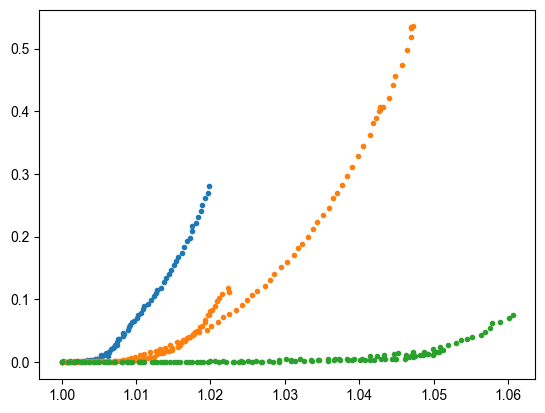

In [5]:
for i_sample in [0,1,2]:
    sample_lmx  = data[1,data[0,:]==i_sample]
    sample_lmy  = data[2,data[0,:]==i_sample]
    sample_sgmx = data[3,data[0,:]==i_sample]
    sample_sgmy = data[4,data[0,:]==i_sample]
    sampleIDind = data[5,data[0,:]==i_sample]
    n=1
    lmxZ = sample_lmx[sampleIDind[:]==n]
    lmyZ = sample_lmy[sampleIDind[:]==n]
    sgmxZ = sample_sgmx[sampleIDind[:]==n]
    sgmyZ = sample_sgmy[sampleIDind[:]==n]
    # print(lmxZ)
    # if all(sampleIDind) == 0:
    # plt.plot(lmyZ, sgmxZ, '.')
    plt.plot(sample_lmy, sample_sgmy, '.')

In [6]:
n_params = 9
def model(i_sample, lmx, lmy, sgmx_gt=None, sgmy_gt=None):
    # Individual parameters
    L_i = numpyro.sample('L_i', dist.Normal(0,1), sample_shape=(n_params,n_params))
    K_i = L_i @ L_i.T
    mu_i = numpyro.sample('mu_i', dist.Normal(0,1), sample_shape=(n_params,))
    with numpyro.plate('plate_i', n_samples):
        params_i = numpyro.sample('params_i', dist.MultivariateNormal(mu_i, K_i))
        
    lmz = 1.0/(lmx*lmy)
    sgmx_pr, sgmy_pr = GOH_vmap(params_i[i_sample], lmx, lmy, lmz)
    sgm_noise = numpyro.sample('sgm_noise', dist.HalfNormal(0.005))
    with numpyro.plate('data', len(lmx)):
        numpyro.sample('obs_sgmx', dist.Normal(sgmx_pr,sgm_noise), obs=sgmx_gt)
        numpyro.sample('obs_sgmy', dist.Normal(sgmy_pr,sgm_noise), obs=sgmy_gt)

In [7]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000) # use 20000 and 200000
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, data[0,:].astype(int), data[1,:], data[2,:], data[3,:], data[4,:])

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [13:17<00:00,  5.01it/s, 1023 steps of size 5.35e-05. acc. prob=0.82]   


In [8]:
sam1=posterior_samples["params_i"][:,0,:]
XRTTE1d = pd.DataFrame(data=sam1, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
# XRTTE1d.to_csv('XRTTE1.csv')

sam2=posterior_samples["params_i"][:,1,:]
XRTTE2d = pd.DataFrame(data=sam2, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
# XRTTE2d.to_csv('XRTTE2.csv')

sam3=posterior_samples["params_i"][:,2,:]
XRTTE3d = pd.DataFrame(data=sam3, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
# XRTTE3d.to_csv('XRTTE3.csv')

IndexError: index 5 is out of bounds for axis 0 with size 5

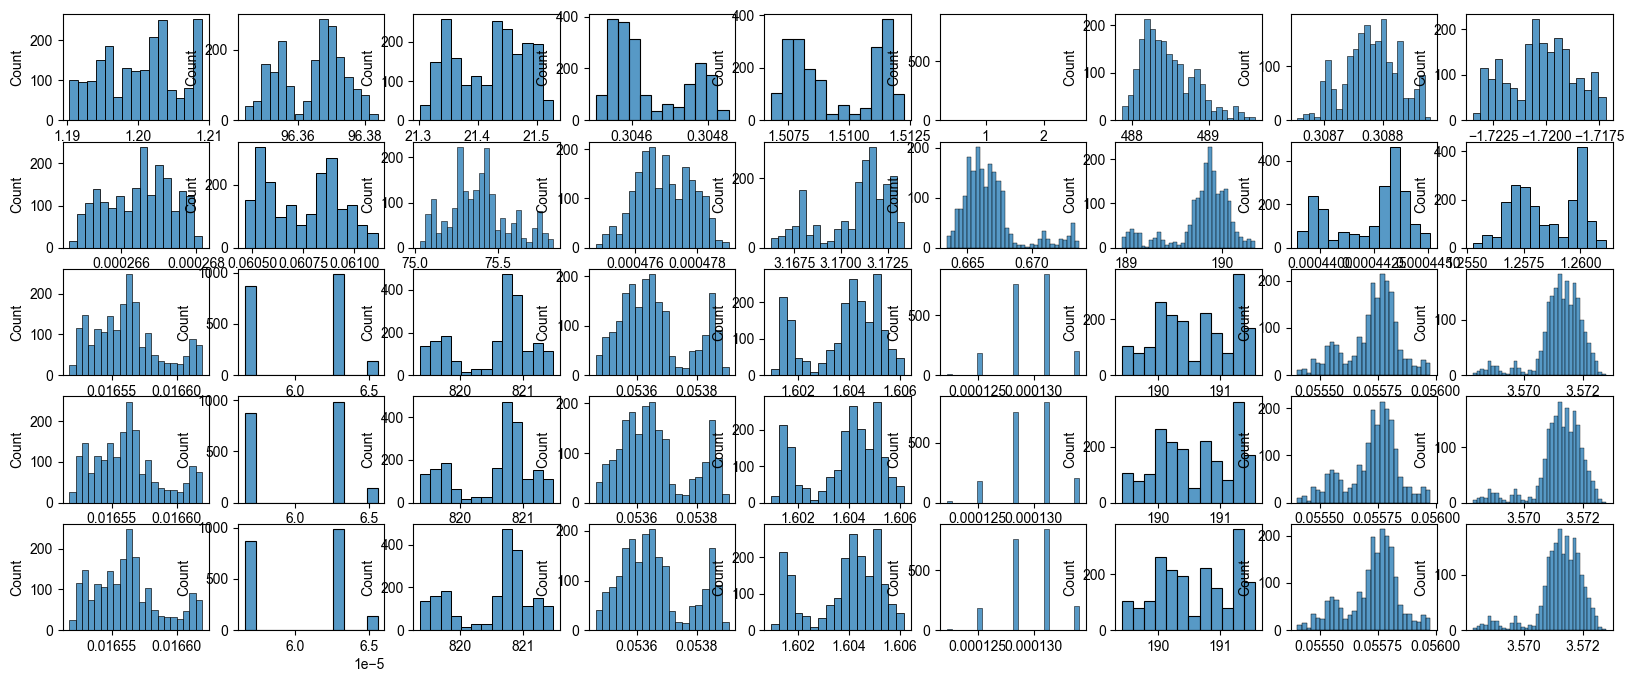

In [9]:
import seaborn as sns

fig, ax = plt.subplots(5, 9, figsize=(20, 8))

for i in range(8):
    # sns.kdeplot(np.array(0.05*norm.cdf(posterior_samples["params_i"][:, i, 0])), ax=ax[i,0], bw_method=0.3, label='')
    # sns.kdeplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 1])), ax=ax[i,1], bw_method=0.3)
    # sns.kdeplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 2])), ax=ax[i,2], bw_method=0.3)
    # sns.kdeplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 3])), ax=ax[i,3], bw_method=0.3)
    # sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4], bw_method=0.3)
    # sns.kdeplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 5])), ax=ax[i,5], bw_method=0.3)
    # sns.kdeplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 6])), ax=ax[i,6], bw_method=0.3)
    # sns.kdeplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 7])), ax=ax[i,7], bw_method=0.3)
    # sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8], bw_method=0.3)

    sns.histplot(np.array(0.05*(jnp.tanh((posterior_samples["params_i"][:, i, 0]))+1)/2), ax=ax[i,0])
    sns.histplot(np.array(100*(jnp.tanh((posterior_samples["params_i"][:, i, 1]))+1)/2), ax=ax[i,1])
    sns.histplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 2]))+1)/2), ax=ax[i,2])
    sns.histplot(np.array(0.33*(jnp.tanh((posterior_samples["params_i"][:, i, 3]))+1)/2), ax=ax[i,3])
    sns.histplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4])
    sns.histplot(np.array(100*(jnp.tanh((posterior_samples["params_i"][:, i, 5]))+1)/2), ax=ax[i,5])
    sns.histplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 6]))+1)/2), ax=ax[i,6])
    sns.histplot(np.array(0.33*(jnp.tanh((posterior_samples["params_i"][:, i, 7]))+1)/2), ax=ax[i,7])
    sns.histplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8])


    # sns.histplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 1])), ax=ax[i,1])
    # sns.histplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 2])), ax=ax[i,2])
    # sns.histplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 3])), ax=ax[i,3])
    # sns.histplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4])
    # sns.histplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 5])), ax=ax[i,5])
    # sns.histplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 6])), ax=ax[i,6])
    # sns.histplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 7])), ax=ax[i,7])
    # sns.histplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8])


# sns.kdeplot(data2, ax=ax[1,1], label='Distribution 2')

ax[0,0].set_title('mu')
ax[0,1].set_title('k1_1')
ax[0,2].set_title('k2_1')
ax[0,3].set_title('kappa1')
ax[0,4].set_title('alpha1')
ax[0,5].set_title('k1_2')
ax[0,6].set_title('k2_2')
ax[0,7].set_title('kappa2')
ax[0,8].set_title('alpha2')

# ax[2,3].spines['left'].set_visible(False)
# ax[0,8].spines['top'].set_visible(False)

# ax[0,0].legend()
# ax[1,0].legend()
# ax[0,1].legend()
# ax[1,1].legend()

# # plt.legend()
# plt.savefig("PosteriorParams_iCTRL.png",dpi=300)
fig.tight_layout(pad=0.1)

plt.show()

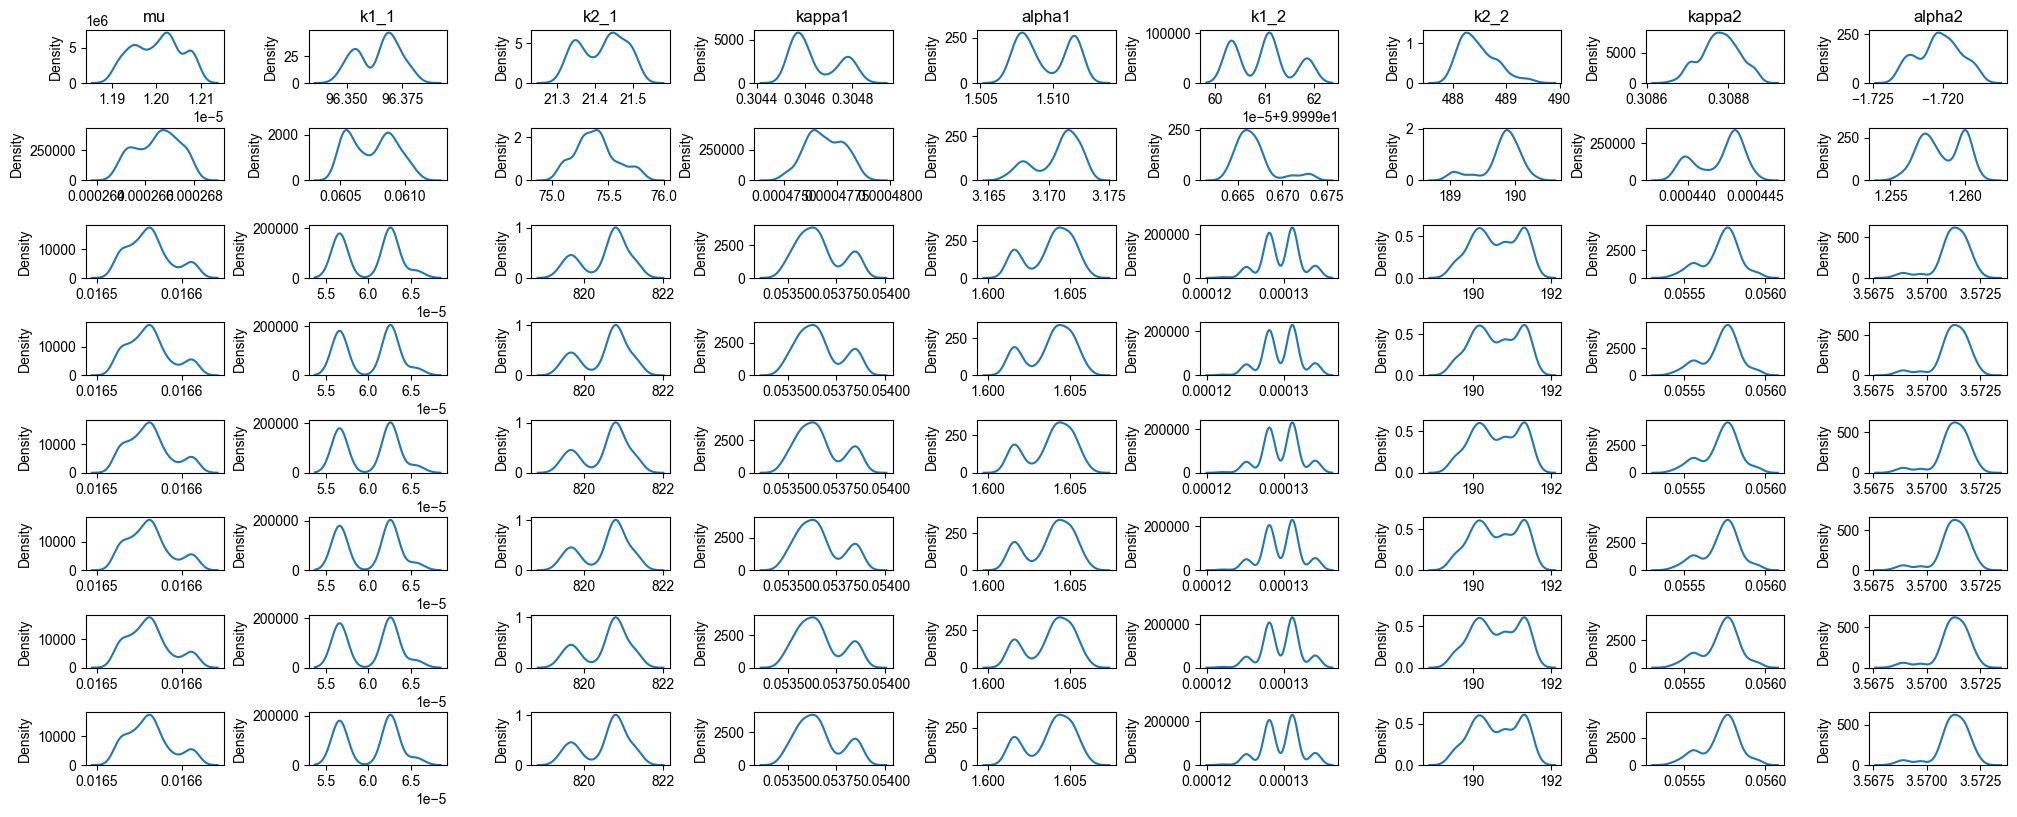

In [10]:
fig, ax = plt.subplots(8, 9, figsize=(20, 8))

for i in range(8):
    sns.kdeplot(np.array(0.05*(jnp.tanh((posterior_samples["params_i"][:, i, 0]))+1)/2), ax=ax[i,0], bw_method=0.3, label='')
    sns.kdeplot(np.array(100*(jnp.tanh((posterior_samples["params_i"][:, i, 1]))+1)/2), ax=ax[i,1], bw_method=0.3)
    sns.kdeplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 2]))+1)/2), ax=ax[i,2], bw_method=0.3)
    sns.kdeplot(np.array(0.33*(jnp.tanh((posterior_samples["params_i"][:, i, 3]))+1)/2), ax=ax[i,3], bw_method=0.3)
    sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4], bw_method=0.3)
    sns.kdeplot(np.array(100*(jnp.tanh((posterior_samples["params_i"][:, i, 5]))+1)/2), ax=ax[i,5], bw_method=0.3)
    sns.kdeplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 6]))+1)/2), ax=ax[i,6], bw_method=0.3)
    sns.kdeplot(np.array(0.33*(jnp.tanh((posterior_samples["params_i"][:, i, 7]))+1)/2), ax=ax[i,7], bw_method=0.3)
    sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8], bw_method=0.3)

    # sns.histplot(np.array(0.05*(jnp.tanh((posterior_samples["params_i"][:, i, 0]))+1)/2), ax=ax[i,0])
    # sns.histplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 1]))+1)/2), ax=ax[i,1])
    # sns.histplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 2]))+1)/2), ax=ax[i,2])
    # sns.histplot(np.array(0.33*(jnp.tanh((posterior_samples["params_i"][:, i, 3]))+1)/2), ax=ax[i,3])
    # sns.histplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4])
    # sns.histplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 5]))+1)/2), ax=ax[i,5])
    # sns.histplot(np.array(1000*(jnp.tanh((posterior_samples["params_i"][:, i, 6]))+1)/2), ax=ax[i,6])
    # sns.histplot(np.array(0.33*(jnp.tanh((posterior_samples["params_i"][:, i, 7]))+1)/2), ax=ax[i,7])
    # sns.histplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8])

    # sns.histplot(np.array(0.05*norm.cdf(posterior_samples["params_i"][:, i, 0])), ax=ax[i,0])
    # sns.histplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 1])), ax=ax[i,1])
    # sns.histplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 2])), ax=ax[i,2])
    # sns.histplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 3])), ax=ax[i,3])
    # sns.histplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4])
    # sns.histplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 5])), ax=ax[i,5])
    # sns.histplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 6])), ax=ax[i,6])
    # sns.histplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 7])), ax=ax[i,7])
    # sns.histplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8])


# sns.kdeplot(data2, ax=ax[1,1], label='Distribution 2')

ax[0,0].set_title('mu')
ax[0,1].set_title('k1_1')
ax[0,2].set_title('k2_1')
ax[0,3].set_title('kappa1')
ax[0,4].set_title('alpha1')
ax[0,5].set_title('k1_2')
ax[0,6].set_title('k2_2')
ax[0,7].set_title('kappa2')
ax[0,8].set_title('alpha2')

# ax[2,3].spines['left'].set_visible(False)
# ax[0,8].spines['top'].set_visible(False)

# ax[0,0].legend()
# ax[1,0].legend()
# ax[0,1].legend()
# ax[1,1].legend()

# # plt.legend()
# plt.savefig("PosteriorParams_iCTRL.png",dpi=300)
fig.tight_layout(pad=0.1)


In [11]:
TableM=np.zeros((5,9))
print(np.shape(TableM))
for i in range(5):
    for j in range(9):
        x=posterior_samples['params_i'][:,i,j]
        if j!=4 and j!=8:
            if j==3 or j==7:
                for m in range(len(x)):
                    x = x.at[m].set(0.33*(jnp.tanh(x[m])+1)/2)
            elif j==1 or j==5:
                for m in range(len(x)):
                    x = x.at[m].set(100*norm.cdf(x[m]))
            elif j==2 or j==6:
                for m in range(len(x)):
                    x = x.at[m].set(1000*norm.cdf(x[m]))
            elif j==0:
                for m in range(len(x)):
                    x = x.at[m].set(0.05*norm.cdf(x[m]))
            else:
                for m in range(len(x)):
                    x = x.at[m].set(jnp.exp(x[m]))

        TableM[i,j]=np.median(x)
        # TableM[i,j]=np.median(x)

# TableM=np.zeros((3,9))
# print(np.shape(TableM))
# for i in range(3):
#     for j in range(9):
#         x=posterior_samples['params_i'][:,i,j]
#         if j!=4 and j!=8:
#             if j==3 or j==7:
#                 for m in range(len(x)):
#                     x = x.at[m].set(0.33*(jnp.tanh(x[m])+1)/2)
#             elif j==1 or j==5:
#                 for m in range(len(x)):
#                     x = x.at[m].set(100*(jnp.tanh(x[m])+1)/2)
#             elif j==2 or j==6:
#                 for m in range(len(x)):
#                     x = x.at[m].set(1000*(jnp.tanh(x[m])+1)/2)
#             elif j==0:
#                 for m in range(len(x)):
#                     x = x.at[m].set(0.05*(jnp.tanh(x[m])+1)/2)
#             # else:
#             #     for m in range(len(x)):
#             #         x = x.at[m].set(jnp.exp(x[m]))

#         TableM[i,j]=np.median(x)
#         # TableM[i,j]=np.median(x)

print(TableM)


XRTTEcsv = pd.DataFrame(data=TableM, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
# XRTTEcsv.to_csv('XRTTEcsv.csv')

(5, 9)
[[ 7.71812154e-07  9.49395447e+01  2.80302048e+01  3.04605156e-01
   1.50878310e+00  1.00000000e+02  4.90743896e+02  3.08779657e-01
  -1.72024322e+00]
 [ 2.23460913e-04  1.06686577e-02  1.05029388e+02  4.76897665e-04
   3.17134666e+00  6.16998434e-01  2.34088211e+02  4.43046418e-04
   1.25820482e+00]
 [ 1.81332156e-02  5.72794208e-11  7.76571411e+02  5.36398664e-02
   1.60416150e+00  6.22173590e-10  2.34784378e+02  5.57509214e-02
   3.57131529e+00]
 [ 1.81332156e-02  5.72794208e-11  7.76571411e+02  5.36398664e-02
   1.60416150e+00  6.22173590e-10  2.34784378e+02  5.57509214e-02
   3.57131529e+00]
 [ 1.81332156e-02  5.72794208e-11  7.76571411e+02  5.36398664e-02
   1.60416150e+00  6.22173590e-10  2.34784378e+02  5.57509214e-02
   3.57131529e+00]]


In [12]:
predictive = Predictive(model, posterior_samples)
samples_predictive = predictive(random.PRNGKey(1), data[0,:].astype(int), data[1,:], data[2,:], None, None)

(75,)
(75,)
(62,)
(0,)
(338,)
(338,)
(338,)
(338,)


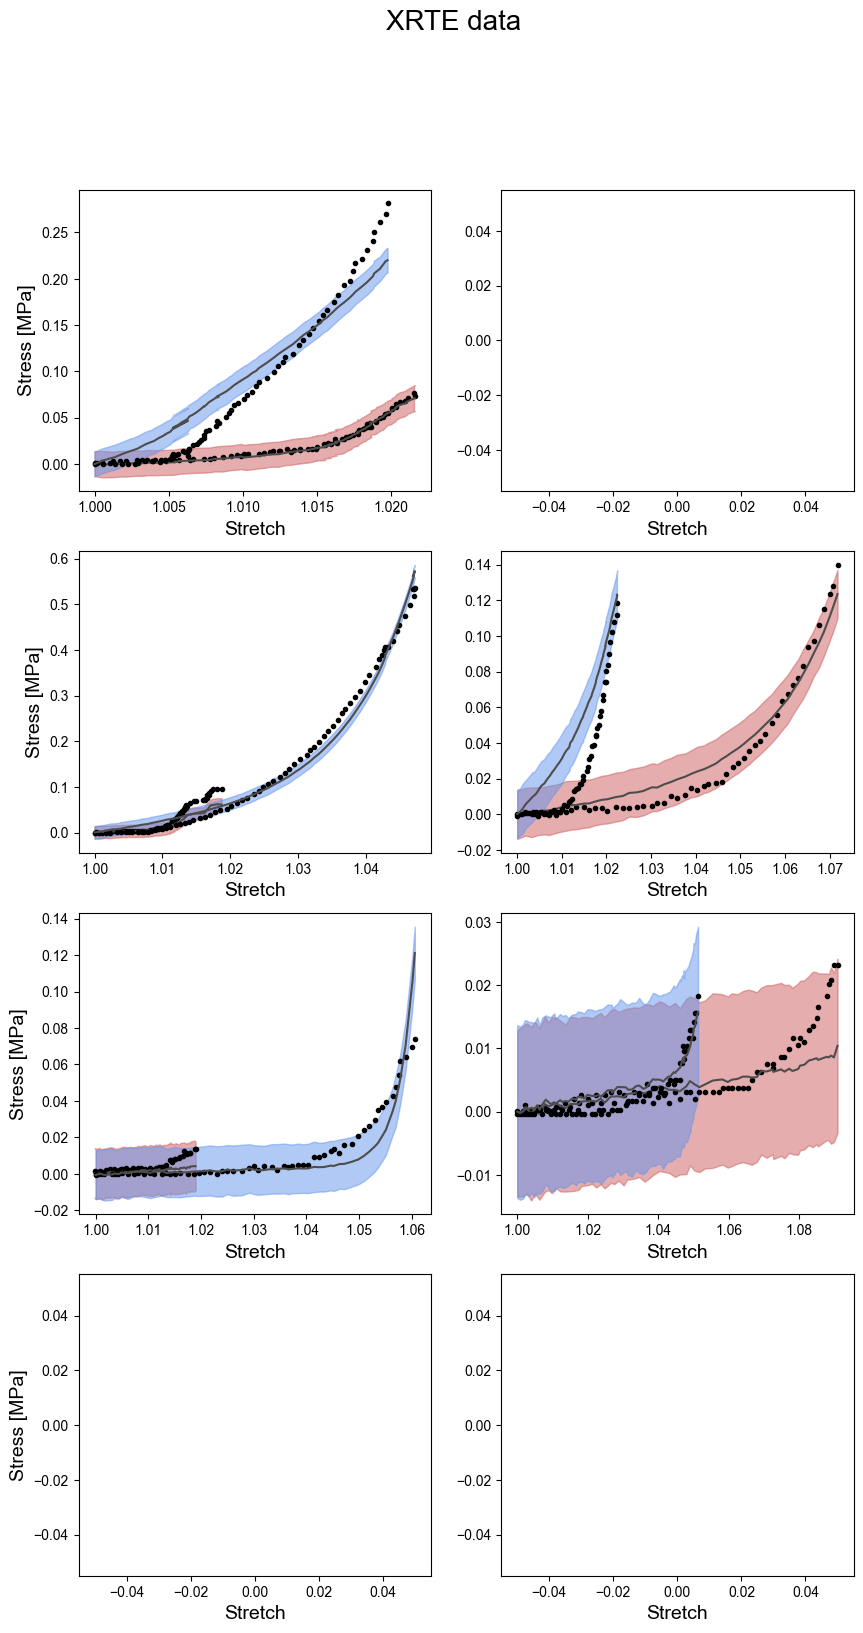

In [19]:
fig, axes = plt.subplots(4,2,figsize=(10,18))

for ax, i_sample in zip(axes, [0,1,2,3]):
    sgmx_pr = samples_predictive['obs_sgmx']
    sgmy_pr = samples_predictive['obs_sgmy']    

    idx = (data[0,:]==i_sample) & (data[5,:]==0)
    # print(idx)
    x = data[1,idx]
    y = data[2,idx]
    # print(x)
    sgmx_gt = data[3,idx] ##sigma real
    sgmx_std = sgmx_pr.std(axis=0)[idx] 
    sgmx_pr = sgmx_pr.mean(axis=0)[idx]
    sgmx_inf = sgmx_pr-sgmx_std
    sgmx_sup = sgmx_pr+sgmx_std

    # if np.all(data[5,:]==0):
    ax[0].plot(x,sgmx_gt,'.', color='0')
    ax[0].plot(x,sgmx_pr,color='0.3')
    ax[0].fill_between(x, sgmx_sup, sgmx_inf, alpha=0.5, color='indianred')
    ax[0].set_ylabel('Stress [MPa]', size=14)
    ax[0].set_xlabel(xlabel='Stretch', size=14)
    # ax[0].set(xlabel='$\lambda_y$', ylabel='$\sigma_{xx}$')

    print(np.shape(sgmx_gt))

    sgmy_gt = data[4,idx]
    sgmy_std = sgmy_pr.std(axis=0)[idx]
    sgmy_pr = sgmy_pr.mean(axis=0)[idx]
    sgmy_inf = sgmy_pr-sgmy_std
    sgmy_sup = sgmy_pr+sgmy_std
    ax[0].plot(y,sgmy_gt,'.', color='0')
    ax[0].plot(y,sgmy_pr, color='0.3')
    ax[0].fill_between(y, sgmy_sup, sgmy_inf, alpha=0.5, color='cornflowerblue')
    ax[0].set_xlabel(xlabel='Stretch', size=14)
        # ax[1].set(xlabel='$\lambda_y$', ylabel='$\sigma_{yy}$')

for ax, i_sample in zip(axes, [0,1,2,3]):
    sgmx_pr = samples_predictive['obs_sgmx']
    sgmy_pr = samples_predictive['obs_sgmy']    

    idx = (data[0,:]==i_sample) & (data[5,:]==1)
    print(np.shape(idx))
    x = data[1,idx]
    y = data[2,idx]
    # print(x)
    sgmx_gt = data[3,idx] ##sigma real
    sgmx_std = sgmx_pr.std(axis=0)[idx] 
    sgmx_pr = sgmx_pr.mean(axis=0)[idx]
    sgmx_inf = sgmx_pr-sgmx_std
    sgmx_sup = sgmx_pr+sgmx_std

    ax[1].plot(x,sgmx_gt,'.', color='0')
    ax[1].plot(x,sgmx_pr,color='0.3')
    ax[1].fill_between(x, sgmx_sup, sgmx_inf, alpha=0.5, color='indianred')
    # ax[1].set_ylabel('Stress [MPa]', size=14)
    ax[1].set_xlabel(xlabel='Stretch', size=14)
    # ax[0].set(xlabel='$\lambda_y$', ylabel='$\sigma_{xx}$')


    sgmy_gt = data[4,idx]
    sgmy_std = sgmy_pr.std(axis=0)[idx]
    sgmy_pr = sgmy_pr.mean(axis=0)[idx]
    sgmy_inf = sgmy_pr-sgmy_std
    sgmy_sup = sgmy_pr+sgmy_std
    ax[1].plot(y,sgmy_gt,'.', color='0')
    ax[1].plot(y,sgmy_pr, color='0.3')
    ax[1].fill_between(y, sgmy_sup, sgmy_inf, alpha=0.5, color='cornflowerblue')
    ax[1].set_xlabel(xlabel='Stretch', size=14)
    # ax[1].set(xlabel='$\lambda_y$', ylabel='$\sigma_{yy}$')

fig.suptitle('XRTE data', fontsize= 20)
# plt.savefig("XRTE_data_i2_2",dpi=300)

[-2.6144     -3.7026334  -1.2534039  -0.8197062   1.6041615  -2.5022702
 -0.72318095 -0.7965713   1.2582048 ]


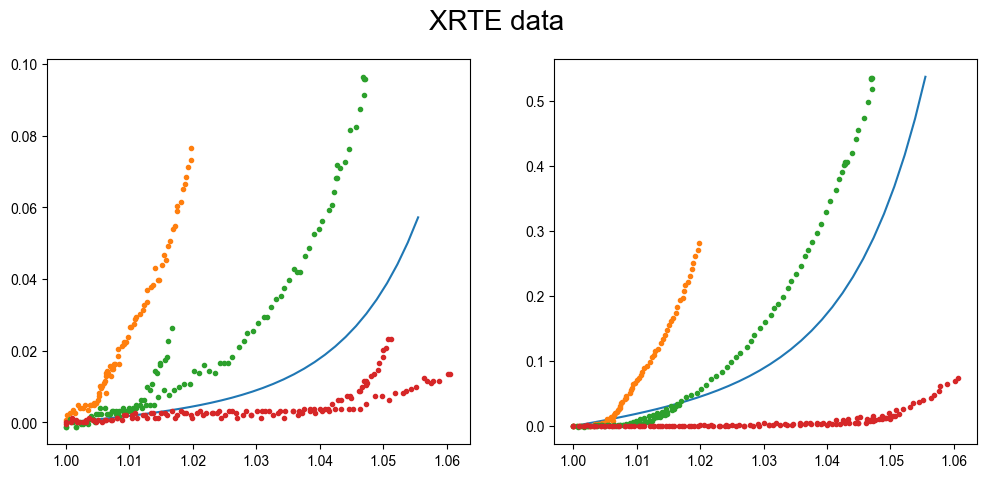

In [20]:
params_i = posterior_samples['params_i']
params_i = params_i[:,:3,:]
params_i = params_i.reshape([-1,9])
params_i = np.median(params_i,axis=0)
print(params_i)

# plot with the median of params_g
lmy = np.linspace(1.0,1.08)
lmx = np.sqrt(lmy)
lmz = 1.0/(lmx*lmy)

sgmx_pr, sgmy_pr = GOH_vmap2(params_i, lmx, lmy, lmz)

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(lmy[0:-15],sgmx_pr[0:-15])
ax[1].plot(lmy[0:-15],sgmy_pr[0:-15])

for i_sample in [0,1,2,3]:   

    idx = data[0,:]==i_sample
    x = data[2,idx]
    # print(x)
    sgmx_gt = data[3,idx] ##sigma real
    sgmy_gt = data[4,idx]

    if i_sample==1:
        ax[1].plot(x[0:-20],sgmy_gt[0:-20],'.')
        ax[0].plot(x[0:-20],sgmx_gt[0:-20],'.')
    else:
        ax[1].plot(x,sgmy_gt,'.')
        ax[0].plot(x,sgmx_gt,'.')


fig.suptitle('XRTE data', fontsize= 20)
plt.savefig("XRTE_data_pred",dpi=300)

[-0.00120297  0.00022556 -0.00120297 -0.0005263   0.00022556  0.00172926
  0.00022556  0.00248112  0.00248112  0.00248112  0.00248112  0.00323297
  0.00248112  0.00323297  0.00323297  0.00248112  0.00398482  0.00323297
  0.00398482  0.00398482  0.00473668  0.00473668  0.00473668  0.00699224
  0.00917261  0.00774409  0.00917261  0.00992447  0.01067632  0.01067632
  0.01443559  0.01368373  0.01593929  0.01443559  0.01368373  0.01669115
  0.01669115  0.01669115  0.01819485  0.02112708  0.02263079  0.02488635
  0.0256382   0.02789376  0.02932229  0.02932229  0.0323297   0.03458526
  0.03533711  0.03759267  0.03977305  0.04278046  0.04202861  0.04202861
  0.04653973  0.0487201   0.05247937  0.05398308  0.05623864  0.05917087
  0.06067457  0.06443384  0.06811792  0.06811792  0.07187719  0.07112534
  0.07262905  0.07638831  0.0815761   0.08232795  0.08751574  0.09127501
  0.09578613  0.09578613  0.0964628 ]


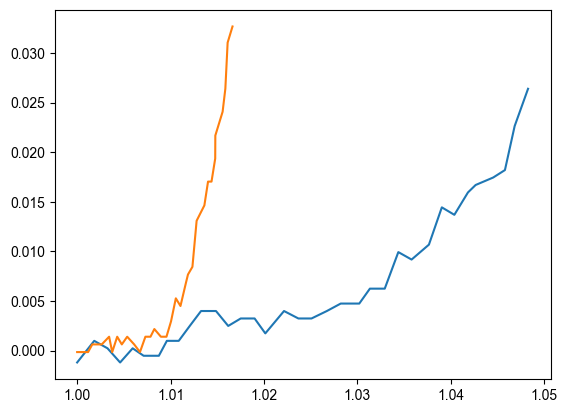

In [34]:
# print(OffY_5XTPA11)
print(OffX_5XTPA11[:,1])
plt.plot(OffY_5XTPA11[0:-20,0],OffY_5XTPA11[0:-20,1])
plt.plot(OffY_5XTPA11[0:-20,2],OffY_5XTPA11[0:-20,3])

# -0.00120297  0.00022556 -0.00120297 -0.0005263   0.00022556  0.00172926
#   0.00022556  0.00248112  0.00248112  0.00248112  0.00248112  0.00323297
#   0.00248112  0.00323297  0.00323297  0.00248112  0.00398482  0.00323297
#   0.00398482  0.00398482  0.00473668  0.00473668  0.00473668  0.00699224
#   0.00917261  0.00774409  0.00917261  0.00992447  0.01067632  0.01067632
#   0.01443559  0.01368373  0.01593929  0.01443559  0.01368373  0.01669115
#   0.01669115  0.01669115  0.01819485  0.02112708  0.02263079  0.02488635
#   0.0256382   0.02789376  0.02932229  0.02932229  0.0323297   0.03458526
#   0.03533711  0.03759267  0.03977305  0.04278046  0.04202861  0.04202861
#   0.04653973  0.04872011  0.05247937  0.05398308  0.05623864  0.05917087
#   0.06067457  0.06443384  0.06811792  0.06811792  0.07187719  0.07112534
#   0.07262904  0.07638831  0.0815761   0.08232795  0.08751574  0.09127501

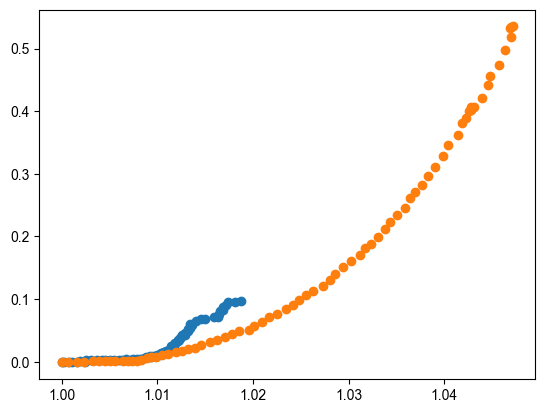

In [26]:
plt.scatter(OffX_5XTPA11[:,0],OffX_5XTPA11[:,1])
plt.scatter(OffX_5XTPA11[:,2],OffX_5XTPA11[:,3])

In [27]:
print(sgmx_gt)

[]
